### Install Libraries...

In [ ]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Libraries...

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import warnings
import sys

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

### Define Data...

In [ ]:
interaction_pairs = # data in list of key-value pair
number_of_nodes = # len(unique_proteins)

### Creating Graph...

In [ ]:
graph = nx.Graph(name='graph')

In [ ]:
for i in range(number_of_nodes):
  graph.add_node(i,name=i)

In [ ]:
graph.add_edges_from(interaction_pairs)

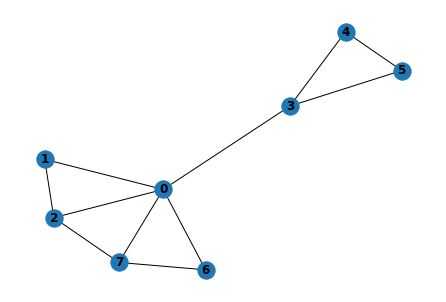


Graph :	 Graph named 'graph' with 8 nodes and 11 edges


In [ ]:
nx.draw(graph,with_labels=True,font_weight='bold')
plt.show()
print("\nGraph :\t", nx.info(graph))

In [ ]:
adjacency_matrix = np.array(nx.attr_matrix(graph)[0])
node_feature_matrix = np.array(nx.attr_matrix(graph)[1])
node_feature_matrix = np.expand_dims(node_feature_matrix,axis=1)

In [ ]:
graph_self_loops = graph.copy()
self_loops = []
for i in range(graph.number_of_nodes()):
  self_loops.append((i,i))
graph_self_loops.add_edges_from(self_loops)
adjacency_matrix_with_loops = np.array(nx.attr_matrix(graph_self_loops)[0])

In [ ]:
degree_matrix = graph_self_loops.degree()
D = np.diag([deg for (n,deg) in list(degree_matrix)])
D_inverse = np.linalg.inv(D)

In [ ]:
A_hat = np.array(nx.attr_matrix(graph_self_loops)[0])
X = np.array(nx.attr_matrix(graph_self_loops)[1])
X = np.expand_dims(X,axis=1)

sum_neighbor_features = np.dot(A_hat,X)
normalised_sum_neighbor_features = np.dot(D_inverse,sum_neighbor_features)

In [ ]:
#kipf and welling
D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)

### Creating Model...

In [ ]:
import keras as ks
import tensorflow as tf
from stellargraph.layer.gcn import GraphConvolution as gc
from stellargraph.layer import GCN, LinkEmbedding

In [ ]:
from stellargraph.layer.appnp import GraphPreProcessingLayer
# input layer
def pipeline(X):
  X=gc(32,activation="relu",kernel_initializer = ks.initializers.GlorotUniform,bias_initializer=ks.initializers.glorot_uniform())(X)
  X=ks.layers.Dropout(0.5)(X)
  X=gc(32,activation="relu",kernel_initializer = ks.initializers.GlorotUniform,bias_initializer= ks.initializers.GlorotUniform())(X)
  output = ks.layers.Dense(1, activation='sigmoid')(X)
  print(X)

In [ ]:
# pipeline(normalised_sum_neighbor_features)

### Other Model 1...

In [ ]:
import stellargraph as sg
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
stellar = sg.StellarGraph(normalised_sum_neighbor_features)
gen = FullBatchLinkGenerator(stellar,method="gcn")

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=gen, dropout=0.3
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = ks.layers.Reshape((-1,))(prediction)

In [ ]:
prediction

<KerasTensor: shape=(1, None) dtype=float32 (created by layer 'reshape_1')>

In [ ]:
model = ks.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=ks.optimizers.Adam(lr=0.01),
    loss=ks.losses.binary_crossentropy,
    metrics=["acc"],
)


### Other Model 2...

In [ ]:
def relu(x):
    return np.maximum(0,x)
np.random.seed(77777)
neurons_hidden_lyr = 4
neurons_output_lyr = 2
W0 = np.random.randn(X.shape[1], neurons_hidden_lyr) * 0.01
W1 = np.random.randn(neurons_hidden_lyr, neurons_output_lyr) * 0.01

def gcn(A,H,W):
    I = np.identity(A.shape[0])
    A_hat = A + I
    D = np.diag(np.sum(A_hat, axis=0))
    D_half_norm = fractional_matrix_power(D, -0.5)
    #kipf and welling
    eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    return relu(eq)

HL1 = gcn(adjacency_matrix,X,W0)
HL2 = gcn(adjacency_matrix,HL1,W1)
print(HL2)

[[0.00058924 0.        ]
 [0.00030571 0.        ]
 [0.00041672 0.        ]
 [0.00059623 0.        ]
 [0.00054097 0.        ]
 [0.00054097 0.        ]
 [0.00052756 0.        ]
 [0.00055376 0.        ]]


### Common output layer


In [ ]:
output = ks.layers.Dense(1, activation='sigmoid')(HL2)

### Using KNN...

In [ ]:
output = output.numpy().tolist()

output_l = []
for o in output:
  output_l.append(o[0])

id = []
for i in range(number_of_nodes):
  id.append(i)

dictio = dict(zip(id,output_l))

In [ ]:
def find_close(inp) -> list():
  list_index = []
  id_copy = id.copy()
  for i in id:
    res = sys.maxsize
    index = -1
    if i not in list_index:
      for d in id_copy:
        if d != inp:
          temp = abs(dictio[d] - dictio[inp])
          if res > temp :
            res, index = temp, d
      list_index.append(index)
      id_copy.remove(index)
    else:
      pass
  return list_index

### Result of KNN...

In [ ]:
# print("Output of Graph : ")
output

[[0.5001641511917114],
 [0.500085175037384],
 [0.5001161694526672],
 [0.5001661777496338],
 [0.500150740146637],
 [0.500150740146637],
 [0.5001469850540161],
 [0.5001543164253235]]

In [ ]:
inp_id = int(input("Enter Node : "))
if inp_id in id:
  print("\n|---------------------------------------------------------------|")
  result = find_close(inp_id)
  count = 0
  try:
    for r in result:
      print("| Rank : ", count," || \t", "Node : ", r, " || \t", dictio[r])
      count += 1
  except TypeError as e:
    print("| Rank : ", count," || \t", "Node : ", result, " || \t", dictio[result])
  print("|---------------------------------------------------------------|")

else:
  print("\n Node is not in Gragh.")

Enter Node : 4

|---------------------------------------------------------------|
| Rank :  0  || 	 Node :  5  || 	 0.500150740146637
| Rank :  1  || 	 Node :  7  || 	 0.5001543164253235
| Rank :  2  || 	 Node :  6  || 	 0.5001469850540161
| Rank :  3  || 	 Node :  0  || 	 0.5001641511917114
| Rank :  4  || 	 Node :  3  || 	 0.5001661777496338
|---------------------------------------------------------------|
